In [4]:
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, 
                      # giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram') 
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP('VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m')

In [5]:
data_df = pd.read_csv('vn_news_226_tdlfr.csv') # Cho cột index là cột PassengerId
data_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### EDA (khám phá dữ liệu)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


In [7]:
data_df.shape

(223, 3)

In [8]:
data_df.index.duplicated().sum()

0

In [9]:
data_df.isna().sum()

text      0
domain    0
label     0
dtype: int64

In [10]:
#check output thiếu
data_df['label'].isna().sum()

0

0    55.156951
1    44.843049
Name: label, dtype: float64

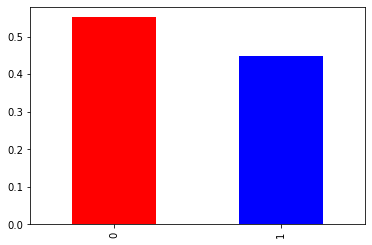

In [11]:
# Tỉ lệ các lớp trong cột output?
data_df.label.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])
data_df['label'].value_counts(normalize=True) * 100

In [12]:
np.average(data_df['text'].apply(lambda x: len(x)))

2554.57399103139

## Mô hình hóa

### Tiền xử lý

In [13]:
y_sr = data_df["label"] # sr là viết tắt của series
X_df = data_df.drop("label", axis=1)

In [14]:
train_X_df, val_X_df, train_y_sr, val_y_sr = \
                              train_test_split(X_df, y_sr, 
                                               test_size=0.2, 
                                               stratify=y_sr,
                                               random_state=7)

In [15]:
train_X_df.shape,train_y_sr.shape

((178, 2), (178,))

In [16]:
val_X_df.shape,val_y_sr.shape

((45, 2), (45,))

In [17]:
with open('vietnamese_stopwords.txt',encoding='utf8') as f:
    stopwords = f.read().splitlines() 
pat = r'\b(?:{})\b'.format('|'.join(stopwords))

In [18]:
class WordPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        
        out_df = X_df.copy()
        out_df['text'] = out_df['text'].str.lower()
        out_df['text'] = out_df['text'].str.replace(pat, '',regex=True)
        out_df['text'] = out_df['text'].str.replace('\W', ' ',regex=True)
        out_df['text'] = out_df['text'].str.replace('[^\w\s]',' ',regex=True)
        out_df['text'] = out_df['text'].apply(annotator.tokenize)
        out_df['text'] = out_df['text'].apply(lambda x: x[0])
        out_df['domain'] = out_df['domain'].str.replace('\W','',regex=True)  
        
        out_df = out_df.sort_index(axis=1)
        return out_df

In [19]:
def dummy_fun(a):
    return a
col_pipeline = ColumnTransformer(
    transformers=[
        ('tfidf',TfidfVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun, 
    token_pattern=None), 'text'),
    ('ohe',OneHotEncoder(handle_unknown='ignore'),['domain'])
    ]
)

In [20]:
mlp_pipeline = make_pipeline(WordPreprocessing(),col_pipeline,StandardScaler(with_mean=False),MLPClassifier(hidden_layer_sizes=(70),
                                 activation='tanh',
                                 solver='lbfgs', max_iter=1000, 
                                 random_state=0))


In [21]:
mlp_pipeline

Pipeline(steps=[('wordpreprocessing', WordPreprocessing()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(preprocessor=<function dummy_fun at 0x0000020FBB75F040>,
                                                                  token_pattern=None,
                                                                  tokenizer=<function dummy_fun at 0x0000020FBB75F040>),
                                                  'text'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['domain'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=70,
                               max_iter=1000, random_state=0,
                               solver='lbfgs'))])

In [22]:

val_accs = []
alphas = [0,0.5,1, 1.5, 2, 2.5]
best_val_acc = 0
best_alpha = None
for alpha in alphas:
    mlp_pipeline.set_params(mlpclassifier__alpha = alpha)
    mlp_pipeline.fit(train_X_df,train_y_sr)
    val_acc = mlp_pipeline.score(val_X_df,val_y_sr)*100
    val_accs.append(val_acc)
    if val_acc>best_val_acc :
        best_val_acc = val_acc
        best_alpha = alpha
print(best_alpha,best_val_acc);

0.5 93.33333333333333


In [23]:
mlp_pipeline.set_params(mlpclassifier__alpha = best_alpha)
mlp_pipeline.fit(X_df,y_sr)

Pipeline(steps=[('wordpreprocessing', WordPreprocessing()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(preprocessor=<function dummy_fun at 0x0000020FBB75F040>,
                                                                  token_pattern=None,
                                                                  tokenizer=<function dummy_fun at 0x0000020FBB75F040>),
                                                  'text'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['domain'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.5,
                               hidden_layer_sizes=70, max_iter=1000,
                               random_state=0, solver='lbfgs'))])

#### LogisticRegression

In [24]:
lr_pipeline = make_pipeline(WordPreprocessing(),col_pipeline,StandardScaler(with_mean=False),LogisticRegression(solver='liblinear'))

In [25]:
val_accs = []
cs = [0.25,0.5, 0.75, 1, 1.25,1.5]
penalties = ['l1', 'l2']
best_val_acc = 0
best_c = None
best_penalty = None
for c in cs:
    for penalty in penalties:
        lr_pipeline.set_params(logisticregression__C = c,logisticregression__penalty = penalty)
        lr_pipeline.fit(train_X_df,train_y_sr)
        val_acc = lr_pipeline.score(val_X_df,val_y_sr)*100
        val_accs.append(val_acc)
        if val_acc>best_val_acc :
            best_val_acc = val_acc
            best_c = c
            best_penalty = penalty
print(best_c,best_penalty,best_val_acc);


0.25 l2 93.33333333333333


In [26]:
lr_pipeline.set_params(logisticregression__C = best_c,logisticregression__penalty = best_penalty)
lr_pipeline.fit(X_df,y_sr)

Pipeline(steps=[('wordpreprocessing', WordPreprocessing()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(preprocessor=<function dummy_fun at 0x0000020FBB75F040>,
                                                                  token_pattern=None,
                                                                  tokenizer=<function dummy_fun at 0x0000020FBB75F040>),
                                                  'text'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['domain'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(C=0.25, solver='liblinear'))])

In [27]:
import joblib
joblib.dump(mlp_pipeline,'mlp_model.sav')
joblib.dump(lr_pipeline,'lr_model.sav')

['lr_model.sav']

In [42]:
import sklearn
sklearn.__version__

'0.24.2'